Tutorial 5: Ray Tracing
=======================

In the last tutorial, our use of `Plane`'s was a bit clunky. We manually had to input `Grid2D`'s to trace them, and keep
track of which `Grid2D`'s were the image-plane`s and which were the source planes. It was easy to make mistakes!

Fortunately, in **PyAutoLens**, you won't actually spend much hands-on time with the `Plane` objects. Instead, you'll
primarily use the `ray-tracing` module, which we'll cover in this example. Lets look at how easy it is to setup the
same lens-plane + source-plane strong lens configuration as the previous tutorial, but with a lot less lines of code!

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Let use the same `Grid2D` we've all grown to know and love by now!

In [2]:
image_plane_grid = al.Grid2D.uniform(
    shape_native=(100, 100), pixel_scales=0.05, sub_size=2
)

For our lens galaxy, we'll use the same SIS `MassProfile` as before.

In [3]:
sis_mass_profile = al.mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6)

lens_galaxy = al.Galaxy(redshift=0.5, mass=sis_mass_profile)

print(lens_galaxy)

Redshift: 0.5
Mass Profiles:
SphericalIsothermal
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0


And for our source galaxy, the same `SphericalSersic` `LightProfile`

In [4]:
sersic_light_profile = al.lp.SphericalSersic(
    centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0, sersic_index=1.0
)

source_galaxy = al.Galaxy(redshift=1.0, light=sersic_light_profile)

print(source_galaxy)

Redshift: 1.0
Light Profiles:
SphericalSersic
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 1.0
effective_radius: 1.0
sersic_index: 1.0


Now, lets use the lens and source galaxies to ray-trace our `Grid2D`, using a `Tracer` from the ray-tracing module. 
When we pass our galaxies into the `Tracer` below, the following happens:

1) The galaxies are ordered in ascending redshift.
2) Planes are created at every one of these redshifts, with the galaxies at those redshifts associated with those planes.

In [5]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

This `Tracer` is composed of a list of planes, in this case two `Plane`'s (the image and source plane).

In [6]:
print(tracer.planes)

[<autogalaxy.plane.plane.Plane object at 0x7f50d330de20>, <autogalaxy.plane.plane.Plane object at 0x7f50d330d670>]


We can access these using the `image_plane` and `source_plane` attributes.

In [7]:
print("Image Plane:")
print(tracer.planes[0])
print(tracer.image_plane)
print()
print("Source Plane:")
print(tracer.planes[1])
print(tracer.source_plane)

Image Plane:

Source Plane:


The most convenient part of the `Tracer` is we can use it to create fully `ray-traced` images, without manually 
setting up the `Plane`'s to do this. The function below does the following

1) Using the lens-total mass distribution, the deflection angle of every image-plane `Grid2D` coordinate is computed.
2) These deflection angles are used to trace every image-plane coordinate to a source-plane coordinate.
3) The light of each traced source-plane coordinate is evaluated using the source-plane `Galaxy`'s `LightProfile`.

In [8]:
traced_image = tracer.image_from_grid(grid=image_plane_grid)
print("traced image pixel 1")
print(traced_image.native[0, 0])
print("traced image pixel 2")
print(traced_image.native[0, 1])
print("traced image pixel 3")
print(traced_image.native[0, 2])

traced image pixel 1
0.21426976064802492
traced image pixel 2
0.22070585920172178
traced image pixel 3
0.22730087364082105


This image appears as the Einstein ring we saw in the previous tutorial.

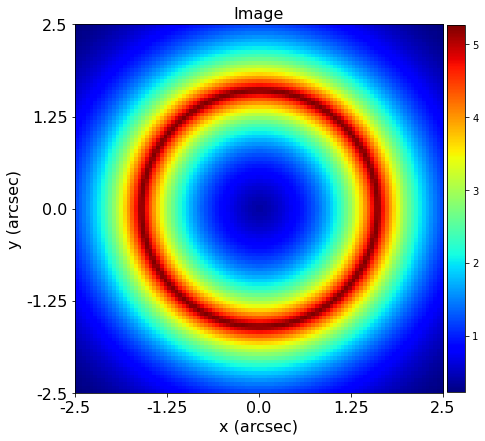

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)
tracer_plotter.figures(image=True)

We can also use the `Tracer` to compute the traced `Grid2D` of every plane, instead of getting the traced image itself:

In [10]:
traced_grids = tracer.traced_grids_of_planes_from_grid(grid=image_plane_grid)

And the source-plane`s `Grid2D` has been deflected.

In [11]:
print("grid source-plane coordinate 1")
print(traced_grids[1].native[0, 0])
print("grid source-plane coordinate 2")
print(traced_grids[1].native[0, 1])
print("grid source-plane coordinate 3")
print(traced_grids[1].native[0, 2])

grid source-plane coordinate 1
[ 1.35612915 -1.35612915]
grid source-plane coordinate 2
[ 1.35042966 -1.3368575 ]
grid source-plane coordinate 3
[ 1.34470204 -1.31767286]


We can use the TracerPlotter to plot these planes and grids.

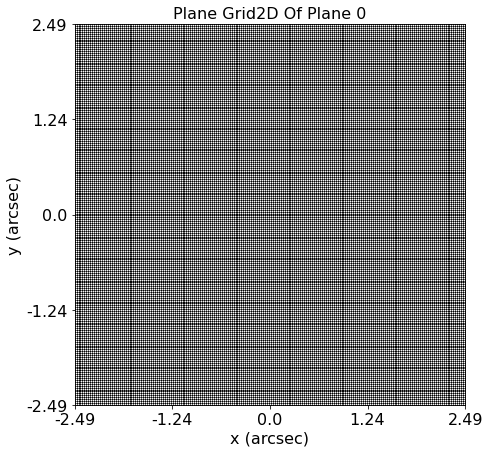

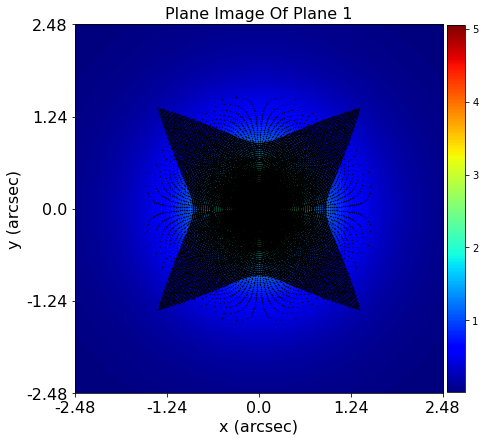

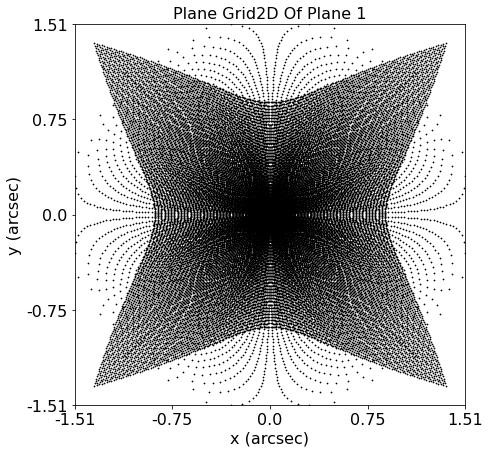

In [12]:
include_2d = aplt.Include2D(grid=True)

tracer_plotter = aplt.TracerPlotter(
    tracer=tracer, grid=image_plane_grid, include_2d=include_2d
)
tracer_plotter.figures_of_planes(plane_image=True, plane_grid=True, plane_index=0)
tracer_plotter.figures_of_planes(plane_image=True, plane_grid=True, plane_index=1)

**PyAutoLens** has tools for plotting a `Tracer`. A ray-tracing subplot plots the following:

1) The image, computed by tracing the source-`Galaxy`'s light `forwards` through the `Tracer`.
2) The source-plane image, showing the source-`Galaxy`'s true appearance (i.e. if it were not lensed).
3) The image-plane convergence, computed using the lens galaxy's total mass distribution.
4) The image-plane gravitational potential, computed using the lens galaxy's total mass distribution.
5) The image-plane deflection angles, computed using the lens galaxy's total mass distribution.

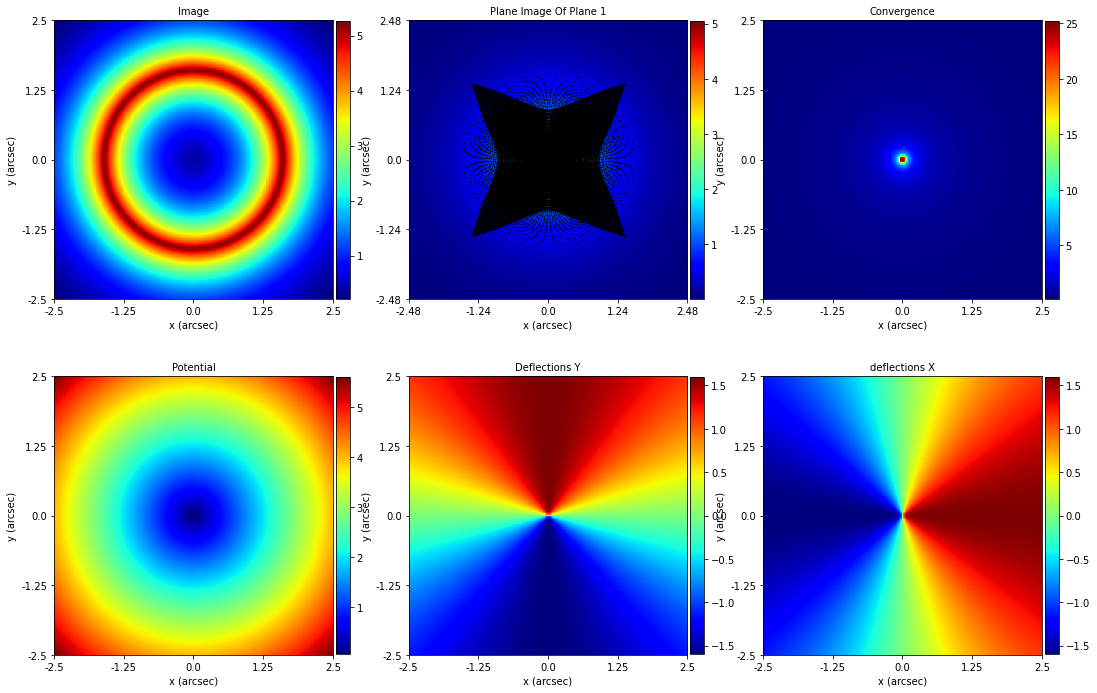

In [13]:
tracer_plotter.subplot_tracer()

Just like for a plane, these quantities attributes can be computed by passing a `Grid2D` (converted to 2D ndarrays
the same dimensions as our input grid!).

In [14]:
convergence = tracer.convergence_from_grid(grid=image_plane_grid)

print("Tracer - Convergence - `Grid2D` coordinate 1:")
print(convergence.native[0, 0])
print("Tracer - Convergence - `Grid2D` coordinate 2:")
print(convergence.native[0, 1])
print("Tracer - Convergence - `Grid2D` coordinate 3:")
print(convergence.native[0, 2])
print("Tracer - Convergence - `Grid2D` coordinate 101:")
print(convergence.native[1, 0])

Tracer - Convergence - `Grid2D` coordinate 1:
0.22741122611024647
Tracer - Convergence - `Grid2D` coordinate 2:
0.22855685270631343
Tracer - Convergence - `Grid2D` coordinate 3:
0.22970813194808845
Tracer - Convergence - `Grid2D` coordinate 101:
0.22855685270631343


Of course, these convergences are identical to the image-plane convergences, as it`s only the lens galaxy that 
contributes to the overall mass of the ray-tracing system.

In [15]:
image_plane_convergence = tracer.image_plane.convergence_from_grid(
    grid=image_plane_grid
)

print("Image-Plane - Convergence - `Grid2D` coordinate 1:")
print(image_plane_convergence.native[0, 0])
print("Image-Plane - Convergence - `Grid2D` coordinate 2:")
print(image_plane_convergence.native[0, 1])
print("Image-Plane - Convergence - `Grid2D` coordinate 3:")
print(image_plane_convergence.native[0, 2])
print("Image-Plane - Convergence - `Grid2D` coordinate 101:")
print(image_plane_convergence.native[1, 0])

Image-Plane - Convergence - `Grid2D` coordinate 1:
0.22741122611024647
Image-Plane - Convergence - `Grid2D` coordinate 2:
0.22855685270631343
Image-Plane - Convergence - `Grid2D` coordinate 3:
0.22970813194808845
Image-Plane - Convergence - `Grid2D` coordinate 101:
0.22855685270631343


I've left the rest below commented to avoid too many print statements, but if you're feeling adventurous go ahead 
and uncomment the lines below!

In [16]:
# print("Potential:")
# print(tracer.potential_from_grid(grid=image_plane_grid))
# print(tracer.image_plane.potential_from_grid(grid=image_plane_grid))
# print("Deflections:")
# print(tracer.deflections_from_grid(grid=image_plane_grid))
# print(tracer.deflections_from_grid(grid=image_plane_grid))
# print(tracer.image_plane.deflections_from_grid(grid=image_plane_grid))
# print(tracer.image_plane.deflections_from_grid(grid=image_plane_grid))

You can also plot the above attributes on individual figures, using appropriate ray-tracing `Plotter` (I've left most 
commented out again for convenience)

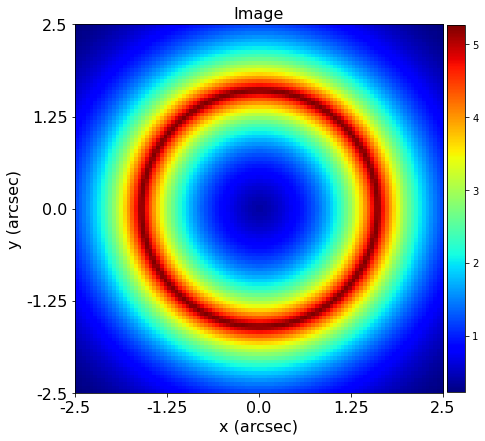

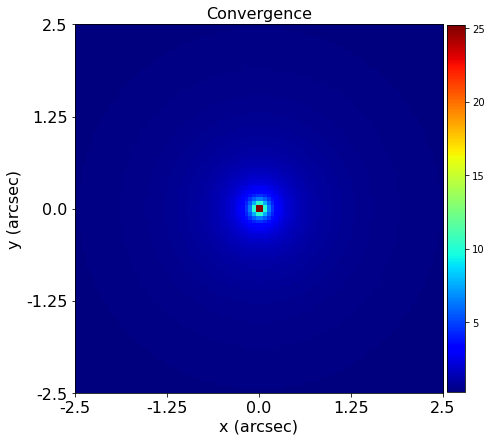

In [17]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)
tracer_plotter.figures(
    image=True,
    convergence=True,
    potential=False,
    deflections_y=False,
    deflections_x=False,
)

In the previous tutorial, we plotted the critical curves on the convergence map of a `MassProfile`. We now introduce
the 'caustic' which is a critical curve mapped to the source-plane. This is computed by calculating the the deflection 
angles of the `Tracer` at the critical curves and ray-tracing them to the source plane.

As discussed in the previous tutorial, critical curves mark regions of infinite magnification. Thus, if a source
appears near a caustic in the source plane it will appear significantly brighter than its true luminosity. 

We can plot both the critical curve and caustic using an `Include2D` object. Note how the critical curve appears
only for the image-plane grid, whereas the caustic only appears in the source plane.

NOTE: Again, numerical issues make the caustic appear 'jagged' when it should be smooth.

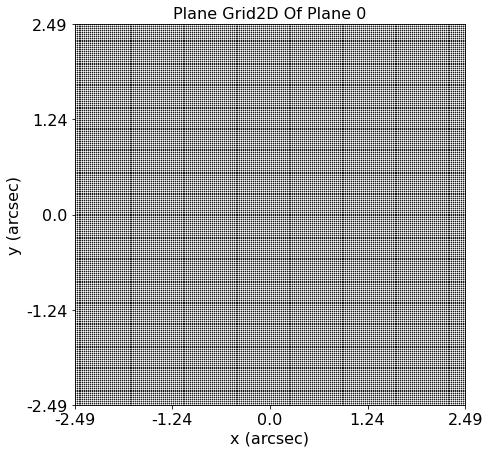

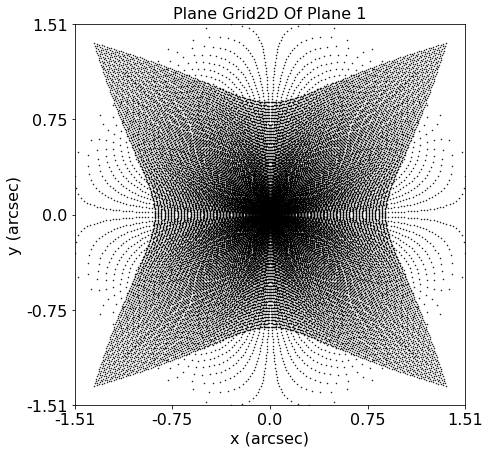

In [18]:
include_2d = aplt.Include2D(critical_curves=True, caustics=True)
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)

tracer_plotter.figures_of_planes(plane_grid=True, plane_index=0)
tracer_plotter.figures_of_planes(plane_grid=True, plane_index=1)

We can also plot the caustic on the source-plane image.

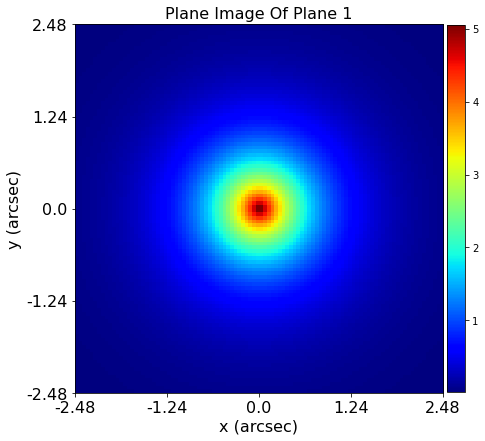

In [19]:
tracer_plotter.figures_of_planes(plane_image=True, plane_index=1)

Caustics also mark the regions in the source-plane where the multiplicity of the strong lens changes. That if,
if a source crosses a caustic, it goes from 2 images to 1 image. Try and show this yourself by changing the (y,x) 
centre of the source-plane galaxy's light profile!

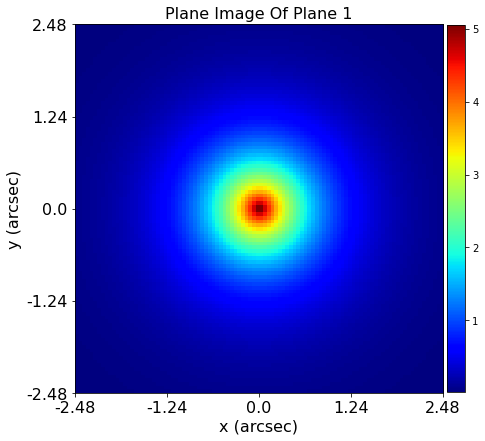

In [20]:
sersic_light_profile = al.lp.SphericalSersic(
    centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0, sersic_index=1.0
)
source_galaxy = al.Galaxy(redshift=1.0, light=sersic_light_profile)
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)
tracer_plotter.figures_of_planes(plane_image=True, plane_index=1)

Before we finish, you might be wondering why do both the image-plane and `Tracer` have the attributes convergence / 
potential / deflection angles, when the two are identical? 

Afterall, only `MassProfile`'s contribute to these quantities, and only the image-plane has galaxies with 
measureable  `MassProfile`'s! There are two reasons:

__Convenience__:  You could always write `tracer.image_plane.convergence_from_grid(grid=grid)`. However, code 
appears neater if you can just write `tracer.convergence_from_grid(grid=grid)`.

__Multi-plane Lensing__:
 
 For now, we're focused on the simplest lensing configuration possible, an image-plane + source-plane configuration. 
 However, there are strong lens system where there are more than 2 planes! 

 In these instances, the  convergence, potential and deflections of each plane is different to the overall values 
 given by the `Tracer`.  This is beyond the scope of this chapter, but be reassured that what you're learning now 
 will prepare you for the advanced chapters later on!

And with that, we're done. You`ve performed your first ray-tracing with **PyAutoLens**! There are no exercises for this 
chapter, and we're going to take a deeper look at ray-tracing in the next chapter.